In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np

import tensorflow as tf
import keras

from keras.layers import Conv2D, Dense, ReLU, BatchNormalization, Input, Flatten, Concatenate, Reshape
from keras import Model
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.losses import BinaryCrossentropy

2022-10-22 00:06:31.878054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load MNIST digits data set

In [26]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [27]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [28]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype=np.float32)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype=np.float32)

In [29]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28, 1), (60000, 10), (10000, 28, 28, 1), (10000, 10))

In [5]:
def mnist_transform(x):
    return (tf.cast(x, tf.float32) / 127.5) - 1.0

2022-10-22 00:06:37.984900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


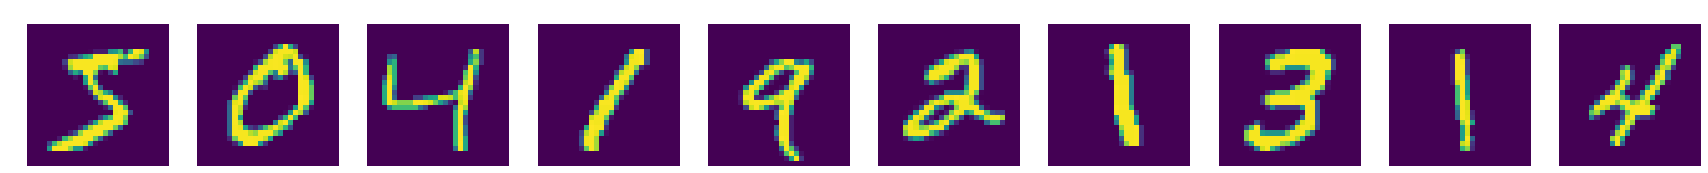

In [6]:
fig, ax = plt.subplots(1, 10, figsize=(30, 50))
for i in range(10):
    ax[i].matshow(mnist_transform(x_train[i, :, :, 0])-1)
    ax[i].axis('off')
fig.show()

## Define Conditional GAN model class

In [7]:
Z_DIM = 100
NUM_CLASSES = 10
IMG_SHAPE = (28, 28, 1)

In [74]:
class CGAN(keras.Model):
    def __init__(self):
        super().__init__()
        self.discriminator = self._build_discriminator()
        self.generator = self._build_generator()
        
    def compile_model(self, discriminator_optimizer, generator_optimizer, loss_fn):
        super().compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.loss_fn = loss_fn
        
        self.discriminator.compile(loss=self.loss_fn,
                                  optimizer=self.discriminator_optimizer)
        
        self.generator.compile(loss=self.loss_fn,
                                  optimizer=self.generator_optimizer)
        
    def _build_generator(self):
        img = Input((Z_DIM,))
        labels = Input((NUM_CLASSES,))

        layer1 = Concatenate()([img, labels])
        layer2 = Dense(np.prod(IMG_SHAPE), 'relu')(layer1)
        
        layer3 = Reshape(IMG_SHAPE)(layer2)
        
        layer4 = Conv2D(
            filters=32,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu',
        )(layer3)
        
        layer5 = Conv2D(
            filters=16,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu',
        )(layer4)
        
        layer6 = Conv2D(
            filters=1,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='tanh',
        )(layer5)
        
        return Model(inputs=[img, labels], outputs=layer6)
    
    def _build_discriminator(self):
        img = Input(IMG_SHAPE)
        labels = Input((NUM_CLASSES,))
        
        layer1 = Conv2D(
            filters=32,
            kernel_size=3,
            strides=2,
            padding='same',
            activation='relu',
        )(img)
        
        layer2 = Conv2D(
            filters=32,
            kernel_size=3,
            strides=2,
            padding='same',
            activation='relu',
        )(layer1)
        
        layer3 = Flatten()(layer2)
        
        layer4 = Concatenate()([layer3, labels])
        layer5 = Dense(64, activation='relu')(layer4)
        layer6 = Dense(32, activation='relu')(layer5)
        
        layer7 = Dense(1, activation='sigmoid')(layer6)
        
        output = layer7
        return Model(inputs=[img, labels], outputs=layer7)
    
    def train_step(self, batch_data):
        img, labels = batch_data
        real_target_labels = np.ones((batch_size, 1), dtype=np.float32)
        fake_target_labels = np.zeros((batch_size, 1), dtype=np.float32)
        
        with tf.GradientTape() as tape:
            # Discriminator Loss
            real_predictions = self.discriminator((img, labels), training=True)
            real_d_loss = self.loss_fn(real_predictions, real_target_labels)
            
            z = tf.random.normal((batch_size, Z_DIM))
            fake_img = self.generator((z, labels), training=False)
            fake_predictions = self.discriminator((fake_img, labels), training=True)
            fake_d_loss = self.loss_fn(fake_predictions, fake_target_labels)
            
            d_loss = real_d_loss + fake_d_loss
        gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.discriminator_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_weights))
        
        with tf.GradientTape() as tape:
            # Generator Loss
            z = tf.random.normal((batch_size, Z_DIM))
            fake_img = self.generator((z, labels), training=True)
            fake_predictions = self.discriminator((fake_img, labels), training=False)
            g_loss = self.loss_fn(fake_predictions, real_target_labels)
            
        gradients = tape.gradient(g_loss, self.generator.trainable_weights)
        self.generator_optimizer.apply_gradients(zip(gradients, self.generator.trainable_weights))
        
        return {'Discriminator Loss': d_loss, 'Generator Loss': g_loss}
    
    def predict(self):
        pass

## Define parameters

In [83]:
epochs = 2
batch_size = 1000

generator_optimizer = Adam(learning_rate=1e-4, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=1e-4, beta_1=0.5)

loss_fn = BinaryCrossentropy()

## Define a Data Iterator

In [90]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(lambda x, y: (mnist_transform(x), y)).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(lambda x, y: (mnist_transform(x), y)).batch(batch_size)


In [70]:
for i, j in train_data.take(1):
    print(i.shape, j.shape)

(100, 28, 28, 1) (100, 10)


## Define Callback

In [101]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self):
        self.d_losses = []
        self.g_losses = []
        
    def on_batch_end(self, batch, logs):
        self.d_losses.append(logs['Discriminator Loss'])
        self.g_losses.append(logs['Generator Loss'])
        
    def on_epoch_end(self, epoch, logs):
        print(logs.keys())

In [102]:
callback = CustomCallback()

## Train CGAN model

In [103]:
cgan = CGAN()

In [99]:
cgan.compile_model(discriminator_optimizer, generator_optimizer, loss_fn)

In [100]:
cgan.fit(train_data,
         epochs=epochs,
         callbacks=[callback]
        )

Epoch 1/2
60/60 [==============================] - 63s 1s/step - Discriminator Loss: 9.4812 - Generator Loss: 8.2822
Epoch 2/2
60/60 [==============================] - 70s 1s/step - Discriminator Loss: 2.5093 - Generator Loss: 13.1699


In [104]:
fig, ax = plt.subplots(10, 10)
for i in range(10):
    for j in range(10):
        

SyntaxError: unexpected EOF while parsing (2190066440.py, line 2)

In [137]:
p = cgan.generator((tf.random.normal(shape=(1, Z_DIM)), np.array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])), training=False)


In [138]:
p.shape

TensorShape([1, 28, 28, 1])

In [139]:
p.numpy().min()

-0.122595064

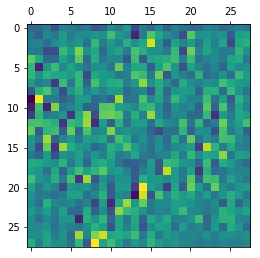

In [140]:
plt.matshow(p[0, :, :, 0], cmap='viridis')

In [117]:
tf.random.normal(shape=(1, Z_DIM)).shape

TensorShape([1, 100])

In [111]:
np.array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]).shape

(1, 10)